In [6]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
import keras
from quantum_model import Quantum_Strategy
from tqdm import tqdm
from tqdm.keras import TqdmCallback
from magic_game import bit_to_num, num_to_bit
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

In [7]:
n = 3
data = np.load(f"./data/data_{n}.npz")
x_train = data['X']; y_train = data['Y']
print(len(x_train))
size = 10000
x_train = x_train[:size]
y_train = y_train[:size]
# ind = np.unique(x_train, axis=0, return_index=True)[1]
# x_train = x_train[ind]
# y_train = y_train[ind]
data_size = len(x_train)
x_test = np.random.randint(0, 2, (1000, x_train.shape[1]))
# # word
# x_train = bit_to_num(x_train.flatten()).reshape(-1, 2*n)
# y_train = bit_to_num(y_train.flatten()).reshape(-1, 2*n)
# x_test = bit_to_num(x_test.flatten()).reshape(-1, 2*n)
# one-hot
x_train = keras.utils.to_categorical(x_train, 2)
x_test = keras.utils.to_categorical(x_test, 2)
# 0, 1, 2, 3 start=4
y_train = np.hstack([np.ones((data_size, 1)) * 2, y_train])
y_train = keras.utils.to_categorical(y_train, 3)
decoder_input_data = y_train[:, :-1]
decoder_target_data = y_train[:, 1:]
print("n=", n)
print("n_qubits=", 4 * n)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
max_decoder_seq_length = decoder_input_data.shape[1]

10000
n= 3
n_qubits= 12
x_train shape: (10000, 12, 2)
y_train shape: (10000, 13, 3)
10000 train samples
1000 test samples


In [8]:
latent_dim = 256

# Define an input sequence and process it.
x_inputs = keras.Input(shape=(None, x_train.shape[-1]))
y_inputs = keras.Input(shape=(None, y_train.shape[-1]))
# stack x and y
whole_inputs = keras.layers.Concatenate(axis=-1)([x_inputs, y_inputs])
gru = keras.layers.GRU(latent_dim, return_sequences=True, return_state=True)
gru_outputs, state = gru(whole_inputs)
final_outputs = keras.layers.Dense(y_train.shape[-1], activation="softmax")(gru_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([x_inputs, y_inputs], final_outputs)

In [9]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5e-3),
)

batch_size = 1000

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=f"model.keras", save_best_only=True, monitor='loss'),
    keras.callbacks.EarlyStopping(monitor="loss", patience=100),
    TqdmCallback(verbose=0)
]
history = model.fit(
    [x_train, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=1000,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=0,
)

0epoch [00:00, ?epoch/s]

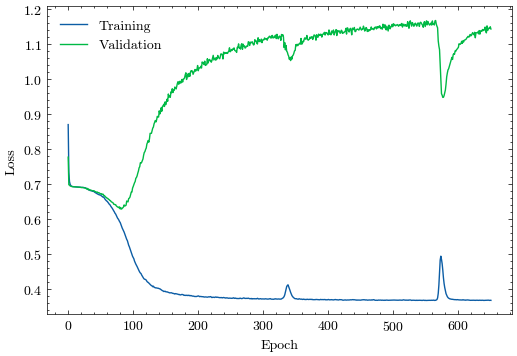

0.7724100530147553


In [13]:
plt.figure(figsize=(6, 4))
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.title(f'n_qubits={4*n}, latent_dim={latent_dim}')
plt.savefig(f'./overfit.pdf')
plt.show()
print(np.mean(np.array(history.history['val_loss'])[-20:]-np.array(history.history['loss'][-20:])))

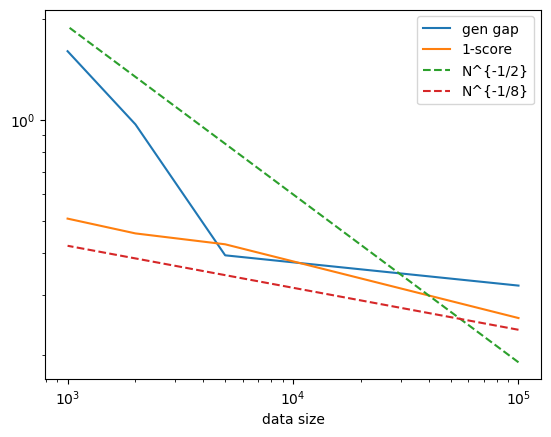

In [68]:
plt.plot([100000, 5000, 2000, 1000], [0.321, 0.395, 0.969, 1.6])
plt.plot([100000, 5000, 2000, 1000], 1 - np.array([0.743, 0.574, 0.541, 0.492]))
# 1/sqrt(N)
plt.plot([100000, 5000, 2000, 1000], (1/np.sqrt([100000, 5000, 2000, 1000])*60), linestyle='--')
# 1/N^{1/8}
plt.plot([100000, 5000, 2000, 1000], (1/np.array([100000, 5000, 2000, 1000])**(1/8)), linestyle='--')
plt.xlabel('data size')
plt.legend(['gen gap', '1-score', 'N^{-1/2}', 'N^{-1/8}'])
plt.xscale('log')
plt.yscale('log')

In [56]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model_pred = keras.models.load_model(f"model.keras")

x_inputs = model.input[0]  # input_1
y_inputs = model.input[1]  # input_2
concat = model.layers[2]  # concatenate_1
gru = model.layers[3]  # lstm_1
init_state = keras.Input(shape=(latent_dim,))
gru_outputs, state = gru(concat([x_inputs, y_inputs]), initial_state=init_state)
outputs = model.layers[4](gru_outputs)

model_pred = keras.Model(
    [x_inputs, y_inputs, init_state], [outputs] + [state]
)

def decode_sequence(x_input):
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, y_train.shape[-1]))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, -1] = 1.0
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    init_state = np.zeros((1, latent_dim))
    while not stop_condition:
        output_tokens, new_state = model_pred.predict(
            [x_input[:, [0]]] + [target_seq] + [init_state], verbose=0
        )

        # Sample a token
        # sampled_char = np.argmax(output_tokens[0, -1, :])
        # random sampling
        sampled_char = np.random.choice(range(y_train.shape[-1]), p=output_tokens[0, -1, :])
        decoded_sentence += [sampled_char]

        # Exit condition: either hit max length
        # or find stop character.
        if len(decoded_sentence) == max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, y_train.shape[-1]))
        target_seq[0, 0, sampled_char] = 1.0
        
        init_state = new_state
        x_input = x_input[:, 1:]

    return decoded_sentence
    
pred = np.zeros((1000, x_train.shape[1]))
for seq_index in tqdm(range(1000)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = x_train[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    pred[seq_index] = decoded_sentence

100%|██████████| 1000/1000 [00:25<00:00, 38.60it/s]


In [57]:
# pred_fin = num_to_bit(pred.astype(np.int16).flatten()).reshape(-1, 4*n)
# inp = num_to_bit(np.argmax(x_test[:1000], axis=-1).astype(np.int16).flatten()).reshape(-1, 4*n)
pred_fin = pred
inp = np.argmax(x_train[:1000], axis=-1)

In [58]:
qs = Quantum_Strategy(n)
results = qs.check_input_output(inp, pred_fin, flatten=False)
checks = np.sum(results, axis=-1) > 0.95 * n
print(np.mean(results), np.mean(checks))

0.9056666666666666 0.743


In [143]:
y = np.argmax(y_train[:1000, 1:], axis=-1)

In [144]:
x = np.sum(inp * (2 ** np.arange(inp.shape[-1])[::-1]).reshape(1, -1), axis=-1)

In [145]:
y = np.sum(y * (2 ** np.arange(y.shape[-1])[::-1]).reshape(1, -1), axis=-1)

In [146]:
y_pred = np.sum(pred_fin * (2 ** np.arange(pred_fin.shape[-1])[::-1]).reshape(1, -1), axis=-1)

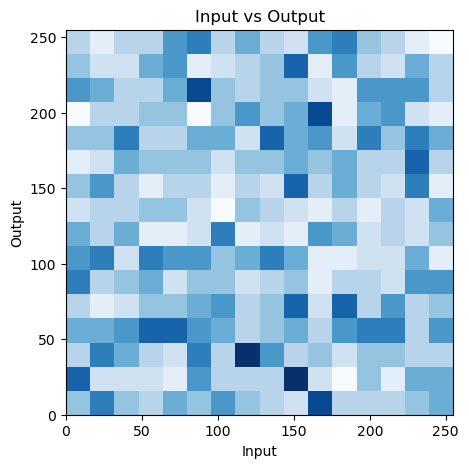

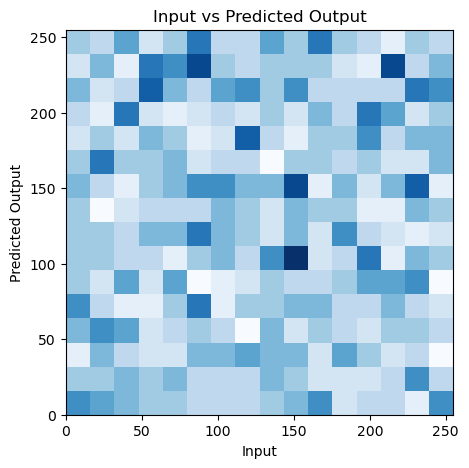

In [152]:
# 2d histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
h1, xed, yed, _ = plt.hist2d(x, y, bins=2**(4*n)//16, cmap='Blues')
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("Input vs Output")
plt.show()

plt.figure(figsize=(5, 5))
h2, xed, yed, _ = plt.hist2d(x, y_pred, bins=2**(4*n)//16, cmap='Blues')
plt.xlabel("Input")
plt.ylabel("Predicted Output")
plt.title("Input vs Predicted Output")
plt.show()



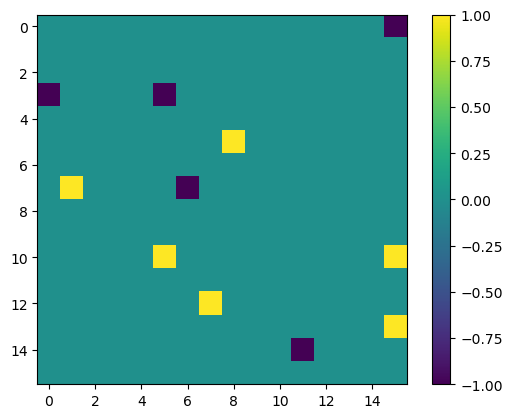

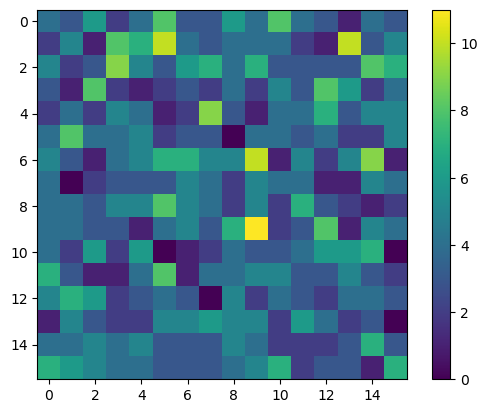

In [153]:
plt.imshow((((1-(h1==0)) - (1-(h2==0))).T)[::-1])
plt.colorbar()
plt.show()

plt.imshow(h2.T[::-1])
plt.colorbar()
plt.show()

In [157]:
n = 2
(2**(4*n))**2

65536

In [2]:
def load_data(n):
    data = np.load(f"data_{n}.npz")
    data_size = len(data['X'])
    x_train = data['X']; y_train = data['Y']
    x_test = np.random.randint(0, 2, (1000, x_train.shape[1]))
    # one-hot
    x_train = keras.utils.to_categorical(x_train, 2)
    x_test = keras.utils.to_categorical(x_test, 2)
    # 0, 1, start=2, end=3
    y_train = np.hstack([np.ones((data_size, 1)) * 2, y_train, np.ones((data_size, 1)) * 3])
    y_train = keras.utils.to_categorical(y_train, 4)
    decoder_input_data = y_train[:, :-1]
    decoder_target_data = y_train[:, 1:]
    print("n=", n)
    print("n_qubits=", 4 * n)
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    print(x_train.shape[0], "train samples")
    print(x_test.shape[0], "test samples")
    max_decoder_seq_length = decoder_input_data.shape[1]
    return x_train, x_test, decoder_input_data, decoder_target_data, max_decoder_seq_length

In [6]:
def build_model_and_train(n, latent_dim, x_train, decoder_input_data, decoder_target_data, verbose=0):
    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None, 2))
    encoder = keras.layers.GRU(latent_dim, return_state=True)
    encoder_outputs, state_h = encoder(encoder_inputs)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = state_h

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None, 4))

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.GRU(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(4, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    )
    batch_size = 1000

    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath=f"model_n{n}_l{latent_dim}.keras", save_best_only=True),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=500),
        TqdmCallback(verbose=0)
    ]

    model.fit(
        [x_train, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=100,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=verbose,
    )
    return model

In [7]:
def sample_and_predict(n, latent_dim, test_size, max_decoder_seq_length, x_train, x_test):
    # Define sampling models
    # Restore the model and construct the encoder and decoder.
    model = keras.models.load_model(f"model_n{n}_l{latent_dim}.keras")

    encoder_inputs = model.input[0]  # input_1
    encoder_outputs, state_h_enc = model.layers[2].output  # lstm_1
    encoder_states = state_h_enc
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    decoder_inputs = model.input[1]  # input_2
    decoder_state_input_h = keras.Input(shape=(latent_dim,))
    decoder_states_inputs = decoder_state_input_h
    decoder_lstm = model.layers[3]
    decoder_outputs, state_h_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs
    )
    decoder_states = state_h_dec
    decoder_dense = model.layers[4]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = keras.Model(
        [decoder_inputs] + [decoder_states_inputs], [decoder_outputs] + [decoder_states]
    )

    def decode_sequence(input_seq):
        # Encode the input as state vectors.
        states_value = encoder_model.predict(input_seq, verbose=0)

        # Generate empty target sequence of length 1.
        target_seq = np.zeros((1, 1, 4))
        # Populate the first character of target sequence with the start character 2.
        target_seq[0, 0, 2] = 1.0

        # Sampling loop for a batch of sequences
        # (to simplify, here we assume a batch of size 1).
        stop_condition = False
        decoded_sentence = []
        while not stop_condition:
            output_tokens, h = decoder_model.predict(
                [target_seq] + [states_value], verbose=0
            )

            # Sample a token
            sampled_char = np.argmax(output_tokens[0, -1, :])
            decoded_sentence += [sampled_char]


            # Exit condition: either hit max length
            # or find stop character.
            if sampled_char == 3 or len(decoded_sentence) > max_decoder_seq_length:
                stop_condition = True

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1, 1, 4))
            target_seq[0, 0, sampled_char] = 1.0

            # Update states
            states_value = h
        return decoded_sentence
    
    pred = np.zeros((test_size, x_train.shape[1]))
    for seq_index in tqdm(range(test_size)):
        # Take one sequence (part of the training set)
        # for trying out decoding.
        input_seq = x_test[seq_index : seq_index + 1]
        decoded_sentence = decode_sequence(input_seq)
        pred[seq_index] = decoded_sentence[:-1]
        
    qs = Quantum_Strategy(n)
    results = qs.check_input_output(np.argmax(x_test[:test_size], axis=-1), pred)
    return np.mean(results), np.std(results)

In [19]:
def write_result(n, latent_dim, result):
    # add results to csv file
    # if n, latent_dim not in csv, add new row
    # if n, latent_dim in csv, append mean and std at the end of the row
    try:
        with open("results.csv", "r") as f:
            lines = f.readlines()
    except:
        lines = ["n,latent_dim,mean,std\n"]
    with open("results.csv", "w") as f:
        for line in lines:
            if f"{n},{latent_dim}" in line:
                f.write(line[:-2] + f",{result[0]},{result[1]}\n")
            else:
                f.write(line)
        if not any([f"{n},{latent_dim}" in line for line in lines]):
            f.write(f"{n},{latent_dim},{result[0]},{result[1]}\n")

In [21]:
n = 2
latent_dim = 64
test_size = 1000
x_train, x_test, decoder_input_data, decoder_target_data, max_decoder_seq_length = load_data(n)
model = build_model_and_train(n, latent_dim, x_train, decoder_input_data, decoder_target_data)
result = sample_and_predict(n, latent_dim, test_size, max_decoder_seq_length, x_train, x_test)
print(result)
write_result(n, latent_dim, result)

n= 2
n_qubits= 8
x_train shape: (10000, 8, 2)
y_train shape: (10000, 10, 4)
10000 train samples
1000 test samples


0epoch [00:00, ?epoch/s]

100%|██████████| 1000/1000 [00:03<00:00, 251.79it/s]

(0.8095, 0.39269549271668497)


In [26]:
write_result(n, latent_dim, result)